## This code was adapted from the original version at https://gist.github.com/ypwhs/5dc1e7ded173a3a76c6823d95d8c72d1#file-preprocessing-ipynb

In [1]:
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import tarfile

C:\Users\Ibrahim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz

In [ ]:
train_tar = tarfile.open('train.tar.gz', 'r:gz')
train_tar.extractall(os.path.join(os.getcwd(),'data'))

test_tar = tarfile.open('test.tar.gz', 'r:gz')
test_tar.extractall(os.path.join(os.getcwd(),'data'))


In [2]:
def showimg(index):
    img = cv2.imread('train/%d.png'%(index+1))
    plt.imshow(img[:,:,::-1])

In [3]:
def get_box_data(data, index):
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = data['/digitStruct/bbox'][index]
    data[box[0]].visititems(print_attrs)
    return meta_data

{'width': [8, 8, 8, 8], 'top': [12, 12, 11, 11], 'label': [1, 6, 4, 8], 'left': [38, 44, 52, 59], 'height': [19, 19, 19, 19]}


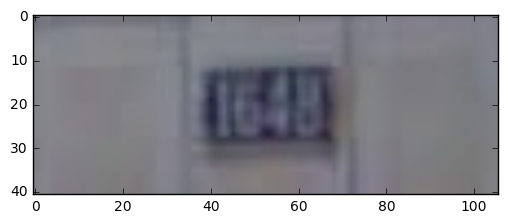

In [4]:
d = h5py.File('train/digitStruct.mat', 'r')
a = 333
showimg(a)
print get_box_data(d, a)

In [5]:
def create_dataset(dataset):
    data = h5py.File('%s/digitStruct.mat'%dataset, 'r')
    df = []
    for i in tqdm(range(len(data['/digitStruct/name']))):
        meta_data = get_box_data(data, i)
        num_length = len(meta_data['label'])
        if num_length < 6:
            dd = {'filename': '%s/%d.png'%(dataset, i+1), 'len': num_length}
            for i in range(5):
                dd['num%d'%(i+1)] = -1
                dd['bbox%d'%(i+1)] = (0, 0, 0, 0)
            for i in xrange(num_length):
                dd['num%d'%(i+1)] = int(meta_data['label'][i])
                dd['bbox%d'%(i+1)] = (meta_data['left'][i], meta_data['top'][i], meta_data['width'][i], meta_data['height'][i])
        df.append(dd)
    df = pd.DataFrame(df)
    for i in range(1, 6):
        df.set_value(df[df['num%d'%i] == 10].index, 'num%d'%i, 0)
    for i in range(1, 6):
        df.set_value(df['num%d'%i].isnull(), 'num%d'%i, 10)
    for i in range(1, 6):
        for j in df['bbox%d'%i][df['bbox%d'%i].isnull()].index:
            df.set_value(j, 'bbox%d'%(i+1), (0,0,0,0))
    
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    df.to_csv('%s.csv'%dataset)


In [6]:
create_dataset('train')

100%|██████████| 33402/33402 [01:54<00:00, 291.97it/s]


In [7]:
create_dataset('test')

100%|██████████| 13068/13068 [00:41<00:00, 317.18it/s]


In [6]:
create_dataset('extra')

100%|██████████| 202353/202353 [13:02<00:00, 258.62it/s]
